In [16]:
from ae_gemma_llm import GemmaLLMControl

glc = GemmaLLMControl()
glc.initialise()
glc.get_answer()

**Reasoning:**

Gas stoves are typically found in kitchens. The cluster that contains the refrigerator and sink is the kitchen cluster. Therefore, we should explore the cluster that is likely to be the kitchen next.

**Answer:**

3

**Reasoning:**

The cluster that contains the refrigerator and sink is the kitchen cluster. The cluster that contains the couch is the living room cluster. The cluster that contains the wooden chair and the microwave is the dining room cluster.

In [1]:
import test_scene_to_grid_map as ttils
ttils.ae_test()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.5.2 (SDL 2.28.5, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
FloorPlan22
xxx............xxxx
xxx............xxxx
xxx............xxxx
xxx...........xxxxx
xxx..........xxxxxx
xxx.........xxxxxxx
xxx........xxxxxxxx
xxx.......xxxxxxxxx
xx........xxxxxxxxx
xx........xxxxxxx..
..........xxxxxxx..
...................
...................
...................


In [1]:
from ai2thor_colab import plot_frames

from ae_robot_simulation_control import RobotNavigationControl

rnc = RobotNavigationControl()
rnc.start_ai2_thor()
rnc.initialise_controller()

In [2]:
event = rnc.controller.step(action="GetReachablePositions")

ArmChair : {'x': -4.334003448486328, 'y': 0.001995176076889038, 'z': -3.5289852619171143}
CoffeeTable : {'x': -2.4740657806396484, 'y': 0.0015519559383392334, 'z': -2.4894556999206543}
CreditCard : {'x': -2.2253689765930176, 'y': 0.5794721841812134, 'z': -3.0478708744049072}
Drawer : {'x': -4.022149562835693, 'y': 0.4777914583683014, 'z': -5.032012939453125}
Drawer : {'x': -4.022149085998535, 'y': 0.169514998793602, 'z': -5.0320048332214355}
Drawer : {'x': -2.981975555419922, 'y': 0.4814813733100891, 'z': -5.03201150894165}
Drawer : {'x': -2.9780020713806152, 'y': 0.16951735317707062, 'z': -5.032003402709961}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
KeyChain : {'x': -4.214433193206787, 'y': 0.3217523396015167, 'z': -3.6542670726776123}
Laptop : {'x': -2.57079815864563, 'y': 0.5791798233985901, 'z': -2.5124337673187256}
Pen : {'x': -2.829010248184204,

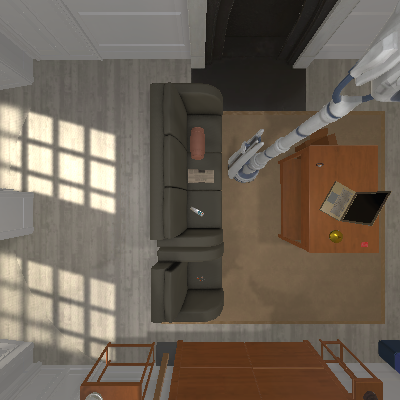

In [18]:
rnc.rotate_left(180)
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
#rnc.show_current_robot_view(ev)
plot_frames(ev.third_party_camera_frames[0])

[('RotateLeft', (0.0, -45, 0.0)), ('MoveAhead', (0.25, 0.0, 0.0)), ('MoveAhead', (0.25, 0.0, 0.0)), ('MoveAhead', (0.25, 0.0, 0.0)), ('MoveAhead', (0.25, 0.0, 0.0)), ('MoveAhead', (0.25, 0.0, 0.0)), ('MoveAhead', (0.25, 0.0, 0.0)), ('MoveAhead', (0.25, 0.0, 0.0)), ('MoveAhead', (0.25, 0.0, 0.0)), ('MoveAhead', (0.25, 0.0, 0.0)), ('LookDown', (0.0, 0.0, 30)), ('LookDown', (0.0, 0.0, 30)), ('RotateRight', (0.0, 45, 0.0))]


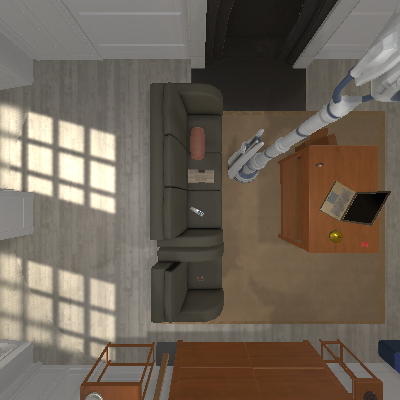

In [14]:
import ae_navigation_functions as aenf

(cur_robot_pos, cur_robot_rt) = rnc.get_agent_pos_and_rotation()
obj_id = rnc.get_obj_id("Dresser")
controller = rnc.get_current_controller()
#print(cur_robot_rt)
(path, plan) = aenf.get_path(controller, obj_id, cur_robot_pos, cur_robot_rt, True)
print(plan)

ev = rnc.controller.last_event
plot_frames(ev.third_party_camera_frames[0])

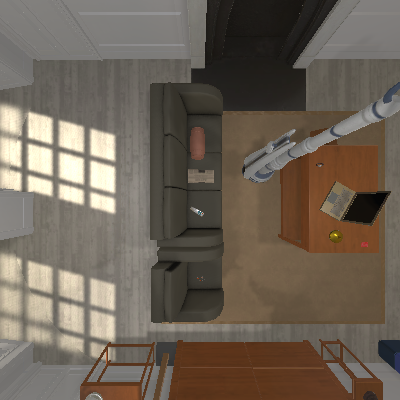

In [15]:
rnc.execute_action_plan(plan)

ev = rnc.controller.last_event
plot_frames(ev.third_party_camera_frames[0])

#path = aenf.get_path(controller, obj_id, cur_robot_pos, cur_robot_rt, False)
#print(path)

#rnc.print_world_state("Vase")

agent_pos : {'x': -2.5, 'y': 0.9027014970779419, 'z': -3.5}
agent_rtn : {'x': -0.0, 'y': 180.00001525878906, 'z': 0.0}
-79.0493526032736
Book : {'x': -2.525362730026245, 'y': 0.6999013423919678, 'z': -5.124803066253662}
Drawer : {'x': -4.022149562835693, 'y': 0.4777914583683014, 'z': -5.032012939453125}
Drawer : {'x': -4.022149085998535, 'y': 0.169514998793602, 'z': -5.0320048332214355}
Drawer : {'x': -2.981975555419922, 'y': 0.4814813733100891, 'z': -5.03201150894165}
Drawer : {'x': -2.9780020713806152, 'y': 0.16951735317707062, 'z': -5.032003402709961}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
FloorLamp : {'x': -4.821146011352539, 'y': 0.00020366907119750977, 'z': -5.118946075439453}
GarbageCan : {'x': -0.969962477684021, 'y': -0.027726799249649048, 'z': -5.058005332946777}
Painting : {'x': -3.372999906539917, 'y': 1.8009999990463257, 'z': -5.392777

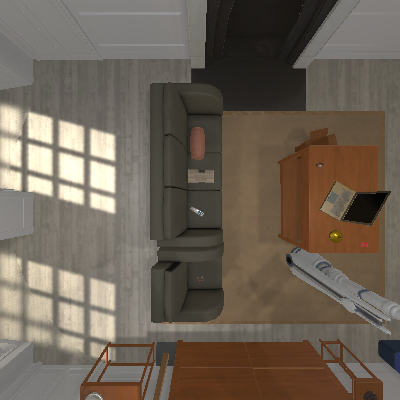

In [6]:
rnc.navigate_to_object("Vase")
rnc.print_current_pose_of_robot()
print(rnc.get_angle_offset_from_target("Vase"))
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])

agent_pos : {'x': -2.5, 'y': 0.9027014970779419, 'z': -3.5}
agent_rtn : {'x': 0.0, 'y': 285.0000305175781, 'z': 0.0}
ArmChair : {'x': -4.334003448486328, 'y': 0.001995176076889038, 'z': -3.5289852619171143}
Drawer : {'x': -4.022149562835693, 'y': 0.4777914583683014, 'z': -5.032012939453125}
Drawer : {'x': -4.022149085998535, 'y': 0.169514998793602, 'z': -5.0320048332214355}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
FloorLamp : {'x': -4.821146011352539, 'y': 0.00020366907119750977, 'z': -5.118946075439453}
KeyChain : {'x': -4.214433193206787, 'y': 0.3217523396015167, 'z': -3.6542670726776123}
Newspaper : {'x': -4.237964630126953, 'y': 0.3441956341266632, 'z': -2.164184093475342}
Pillow : {'x': -4.282398700714111, 'y': 0.42073073983192444, 'z': -1.7359906435012817}
RemoteControl : {'x': -4.292991638183594, 'y': 0.33039507269859314, 'z': -2.6639568805694

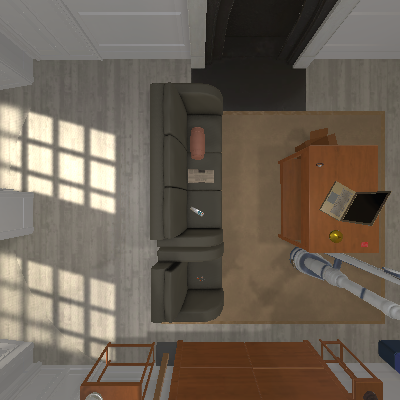

In [7]:
rnc.rotate_to_face_target("Vase")
rnc.print_current_pose_of_robot()
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])

Book : {'x': -2.525362730026245, 'y': 0.6999013423919678, 'z': -5.124803066253662}
CoffeeTable : {'x': -2.4740657806396484, 'y': 0.0015519559383392334, 'z': -2.4894556999206543}
CreditCard : {'x': -2.2253689765930176, 'y': 0.5794721841812134, 'z': -3.0478708744049072}
Drawer : {'x': -2.981975555419922, 'y': 0.4814813733100891, 'z': -5.03201150894165}
Drawer : {'x': -2.9780020713806152, 'y': 0.16951735317707062, 'z': -5.032003402709961}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
GarbageCan : {'x': -0.969962477684021, 'y': -0.027726799249649048, 'z': -5.058005332946777}
Laptop : {'x': -2.57079815864563, 'y': 0.5791798233985901, 'z': -2.5124337673187256}
Painting : {'x': -3.372999906539917, 'y': 1.8009999990463257, 'z': -5.392777442932129}
Pen : {'x': -2.829010248184204, 'y': 0.7048501372337341, 'z': -4.962978363037109}
Shelf : {'x': -2.475966215133667, '

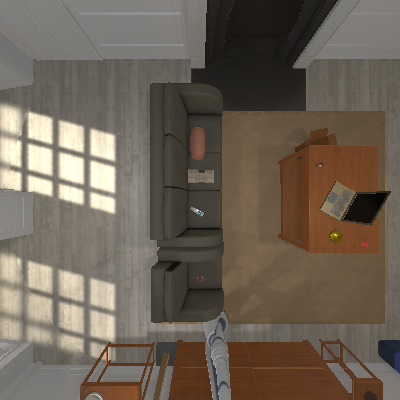

In [8]:
#aa = rnc.get_visible_objects(True)
rnc.navigate_to_object("Drawer")
rnc.rotate_to_face_target("Drawer")
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])

In [2]:
import prior

dataset = prior.load_dataset("procthor-10k")

AE: https://api.github.com/repos/allenai/procthor-10k/commits?sha=main
[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9224.62it/s]


In [14]:
house = dataset["train"][20]

for room in house["rooms"]:
    print(room["roomType"] + " # " + str(room["floorPolygon"]))

#print(house["rooms"][0])

Bedroom # [{'x': 8.349, 'y': 0, 'z': 0.0}, {'x': 8.349, 'y': 0, 'z': 6.679}, {'x': 13.358, 'y': 0, 'z': 6.679}, {'x': 13.358, 'y': 0, 'z': 0.0}]
Bathroom # [{'x': 5.009, 'y': 0, 'z': 0.0}, {'x': 5.009, 'y': 0, 'z': 3.339}, {'x': 5.009, 'y': 0, 'z': 5.009}, {'x': 6.679, 'y': 0, 'z': 5.009}, {'x': 6.679, 'y': 0, 'z': 6.679}, {'x': 8.349, 'y': 0, 'z': 6.679}, {'x': 8.349, 'y': 0, 'z': 0.0}]
Bedroom # [{'x': 6.679, 'y': 0, 'z': 6.679}, {'x': 6.679, 'y': 0, 'z': 10.018}, {'x': 6.679, 'y': 0, 'z': 11.688}, {'x': 13.358, 'y': 0, 'z': 11.688}, {'x': 13.358, 'y': 0, 'z': 6.679}, {'x': 8.349, 'y': 0, 'z': 6.679}]
Bathroom # [{'x': 5.009, 'y': 0, 'z': 13.358}, {'x': 6.679, 'y': 0, 'z': 13.358}, {'x': 6.679, 'y': 0, 'z': 11.688}, {'x': 6.679, 'y': 0, 'z': 10.018}, {'x': 5.009, 'y': 0, 'z': 10.018}]
Kitchen # [{'x': 0.0, 'y': 0, 'z': 3.339}, {'x': 0.0, 'y': 0, 'z': 10.018}, {'x': 5.009, 'y': 0, 'z': 10.018}, {'x': 6.679, 'y': 0, 'z': 10.018}, {'x': 6.679, 'y': 0, 'z': 6.679}, {'x': 6.679, 'y': 0, '

In [5]:
from ai2thor.controller import Controller
import ai2thor_colab
ai2thor_colab.start_xserver()
house = dataset["train"][83]
controller = Controller(scene=house,
            width=640,
            height=420,
            fieldOfView=120,
            # step sizes
            gridSize=0.25,
            snapToGrid=True)

from PIL import Image
Image.fromarray(controller.last_event.frame)

event = controller.step(action="RotateRight")
Image.fromarray(event.frame)
print(house.rooms)

AttributeError: 'dict' object has no attribute 'rooms'

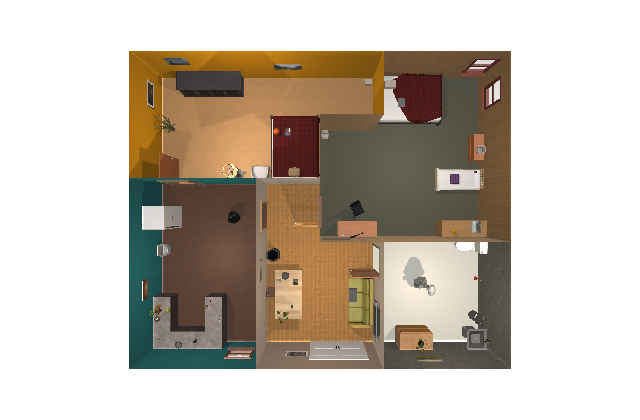

In [10]:
import copy

def get_top_down_frame():
    # Setup the top-down camera
    event = controller.step(action="GetMapViewCameraProperties", raise_for_failure=True)
    pose = copy.deepcopy(event.metadata["actionReturn"])

    bounds = event.metadata["sceneBounds"]["size"]
    max_bound = max(bounds["x"], bounds["z"])

    pose["fieldOfView"] = 50
    pose["position"]["y"] += 1.1 * max_bound
    pose["orthographic"] = False
    pose["farClippingPlane"] = 50
    del pose["orthographicSize"]

    # add the camera to the scene
    event = controller.step(
        action="AddThirdPartyCamera",
        **pose,
        skyboxColor="white",
        raise_for_failure=True,
    )
    top_down_frame = event.third_party_camera_frames[-1]
    return Image.fromarray(top_down_frame)


get_top_down_frame()